In [1]:
from visualizer import get_local
get_local.activate()
from models.transformer_text_query_v7 import MainModule
from data.dataset_mix_visual import PTData
from utils.parser import parse_args, load_config
from utils.util import IoU, EMA, cos_similar
from utils.config.default import get_cfg
from utils import loss
from utils.visualization import visualization, visual_attn, visual_overall

import tqdm
import torch
import os.path as osp
from torch import optim
from torch.utils.data import DataLoader
import os
import numpy as np
from torch.optim.lr_scheduler import LambdaLR
from utils.util import IoU

from torch.utils.tensorboard import SummaryWriter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/jjy/miniconda3/envs/dt2/lib/python3.9/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
cfg = get_cfg()
cfg.merge_from_file('test.yaml')
np.random.seed(cfg.RNG_SEED)
torch.manual_seed(cfg.RNG_SEED)
    # device_ids = [0, 1, 2, 3]

val_dataset = PTData(cfg, train=False)
val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False
)

In [3]:
model = MainModule(cfg.MODEL.ML, cfg.MODEL.TD).to(device)
matcher = loss.HungarianMatcher(1, 0).to(device)

In [4]:
checkpoint_path = osp.join(cfg.OUTPUT_DIR, 'best_checkpoint.pth')

if osp.exists(checkpoint_path):
    print('Resuming training: loading model from: {0}'.format(checkpoint_path))
    checkpoint = torch.load(checkpoint_path, map_location="cpu")

    model.load_state_dict(checkpoint['model_state'])

query = torch.randn((1, cfg.MODEL.NUM_QUERY, cfg.MODEL.EMBED_DIM)).to(device)

Resuming training: loading model from: ./output/transformer_tq_v5/best_checkpoint.pth


/home/jjy/miniconda3/envs/dt2/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/home/jjy/miniconda3/envs/dt2/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180487213/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


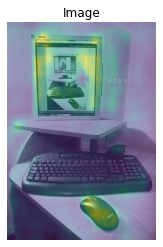

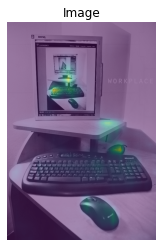

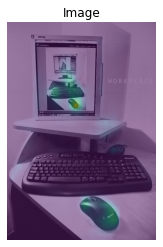

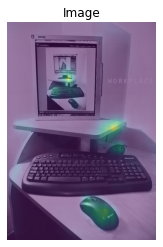

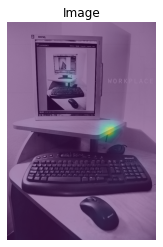

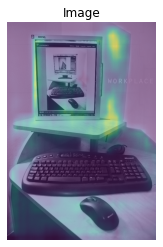

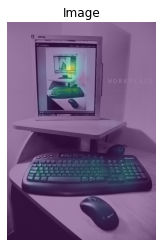

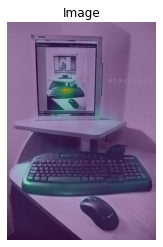

tensor([7473])


In [5]:
model.eval()
with torch.no_grad():
    
    for i, (pure_image, image, segms, noun_index, gt_noun, file_name) in enumerate(val_loader):
        
        if file_name.item() != 7473:
            continue
        image = image.to(device)
        noun_index = noun_index.to(device)
        segms = segms.to(device)

        gt_noun = gt_noun.to(device)
        # gt_noun[:, 0] = unknown_word.unsqueeze(dim=0)

        bsz = image.shape[0]
        
        h, w = pure_image.shape[1], pure_image.shape[2]
        
        mask, word_embed, gt_noun = model(image, gt_noun, noun_index)

        cache = get_local.cache
        
        att = np.array(cache['ScaledDotProductAttention.forward'][2])
        
        mask = mask.to(device)
        word_embed = word_embed.to(device)
        
        mask = torch.nn.functional.interpolate(mask, (h, w), mode='bilinear')
        segms = torch.nn.functional.interpolate(segms, (h, w), mode='bilinear')

        mask[mask >= 0.4] = 1
        mask[mask < 0.4] = 0
        
        temp_iou = 0
        flag = 0
        for b in range(bsz):

            max_pos = np.argwhere(noun_index[b].cpu().numpy() == 0)[0][0]

    
            pred_mask = mask[b, 1:max_pos+1]
            tgt_mask = segms[b, :max_pos]
            
            
            for j in range(max_pos):

                iou = IoU(pred_mask[j], tgt_mask[j]).item()
                temp_iou += iou
                
                '''
                if iou < 0.8:
                    flag = 1
                    break
                '''
                
            if flag==0:
                visual_attn(pure_image[b], att)
                print(file_name)
                # visual_overall(pure_image[b], tgt_mask.cpu(), pred_mask.cpu(), show_img=True, out_file=False)
                # visualization(pure_image[b], tgt_mask.cpu(), pred_mask.cpu(), show_img=True)